In [39]:
import pickle

with open('../trends/rails_x_axis_lines.pkl', 'rb') as f:
    conflict_trends = pickle.load(f)


In [40]:
lines = []

for c in conflict_trends:
    # lines.append([[x, y]for x, y in zip(c['x_axis'], c['counts'])])
    lines.append(c['counts'])

In [41]:
lines

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  30],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  147,
  147,
  147,
  147,
  147,
  147,
  147,
  147,
  147],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [42]:
def max_length(lines):
    return max([len(line) for line in lines])

def padding(line, max_length):
    return line + [0] * (max_length - len(line))

def to_timestamp(line):
    return [[dt.timestamp(), value] for dt, value in line]

In [43]:
from tslearn.clustering import TimeSeriesKMeans
import numpy as np

In [46]:
max_pad_length = max_length(lines)
lines_padding = [padding(line, max_pad_length) for line in lines]
lines = np.array(lines_padding)
np.expand_dims(lines, axis=1)
lines

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [49]:
kmeans = TimeSeriesKMeans(n_clusters=9, metric="dtw",n_jobs=8)
labels = kmeans.fit_predict(lines)
labels

array([1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 6, 1, 6, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 6, 7, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 6,
       1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 6, 6, 0, 5, 1,
       1, 1, 1, 0, 1, 1, 6, 0, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 4, 1, 1, 1, 1, 6, 1, 6, 0, 1, 1, 1, 1, 6, 1, 1,
       1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 6, 0, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1,
       1, 1, 1, 1, 1, 6, 1, 1, 6, 1, 1, 4, 1, 0, 1, 1, 6, 1, 1, 1, 4, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 6, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [51]:
cluster_dict = {}
for index, label in enumerate(labels):
    label = label.item()
    if label not in cluster_dict:
        cluster_dict[label] = []
    cluster_dict[label].append(index)


In [52]:
with open(f'../cluster/rails_lines_cluster_dict.pkl', 'wb') as f:
    pickle.dump(cluster_dict, f)

In [53]:
with open(f'../cluster/rails_lines_cluster_dict.pkl', 'rb') as f:
    cluster_dict = pickle.load(f)

In [54]:
cluster_dict

{1: [0,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  24,
  26,
  27,
  28,
  29,
  30,
  32,
  33,
  34,
  35,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  51,
  52,
  53,
  54,
  55,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  66,
  67,
  68,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  81,
  82,
  87,
  88,
  89,
  90,
  92,
  93,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  107,
  108,
  109,
  110,
  111,
  114,
  115,
  117,
  118,
  119,
  120,
  122,
  125,
  126,
  127,
  128,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  139,
  140,
  141,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  156,
  159,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
  184,
  185,
  186,
  187,
  

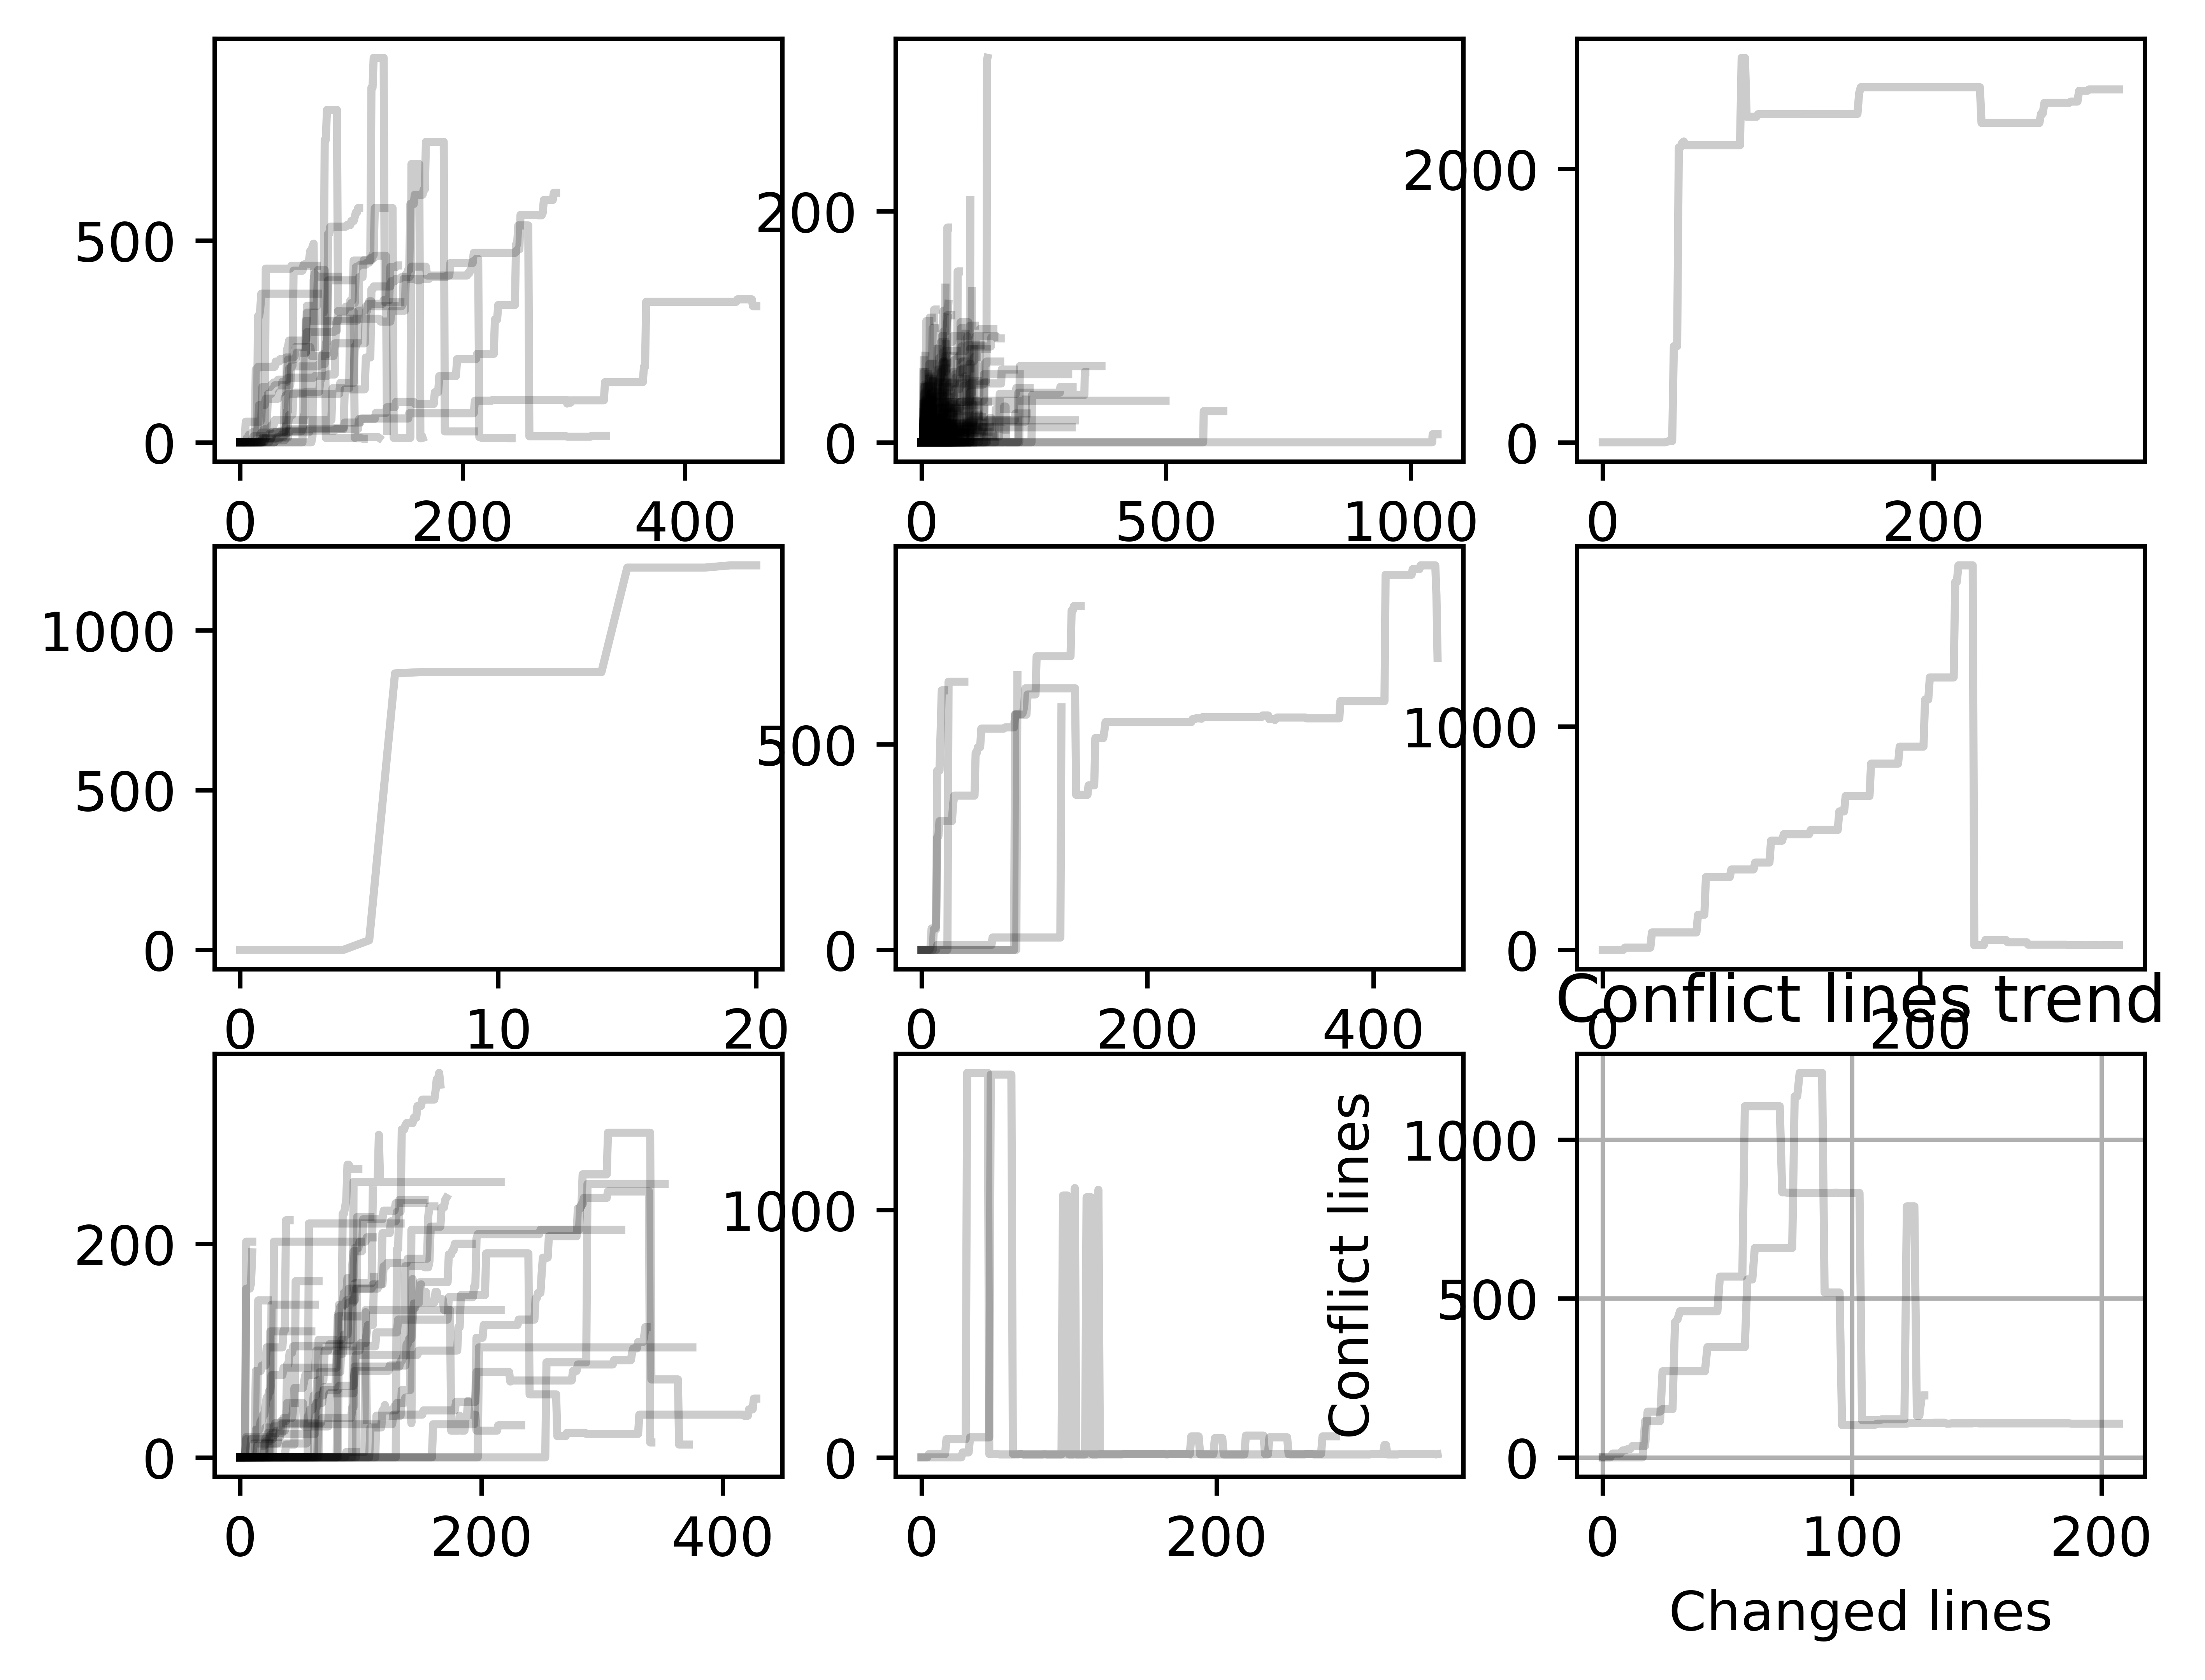

In [56]:
import matplotlib.pyplot as plt

from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.preprocessing import TimeSeriesResampler

fig, axes = plt.subplots(3, 3 ,dpi=1000)
plt.grid(True)

for id, cluster in cluster_dict.items():
    ax = axes.flat[id]
    time_series = []
    for i in cluster:
        trend = conflict_trends[i]
        time_series.append(trend['counts'])
        ax.plot(list(range(len(trend['counts']))), trend['counts'], "k-", alpha=.2)
    target_length = max_length(time_series)
    resampled_time_series = TimeSeriesResampler(sz=target_length).fit_transform(time_series)
    ax.plot(dtw_barycenter_averaging(resampled_time_series).ravel(), "r-", linewidth=2)
    plt.title('Conflict lines trend')

    # 添加标题和标签
    plt.xlabel('Changed lines')
    plt.ylabel('Conflict lines')


ValueError: x and y must have same first dimension, but have shapes (280, 1056) and (295680, 1)

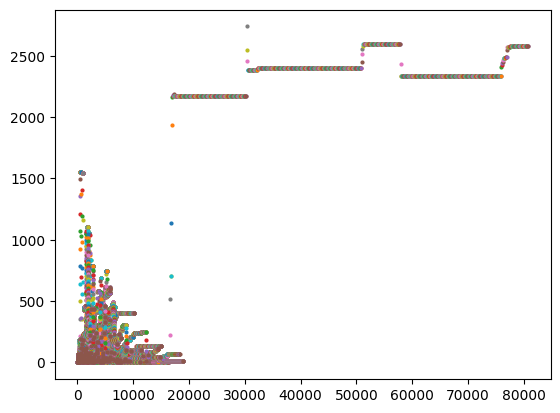

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d

def interpolate(x, y, max_length):
    f_y = interp1d(x, y, kind='linear')  # 对 y 进行线性插值

    # 生成插值后的 x 值
    x_new = np.linspace(min(x), max(x), max_length)
    # 使用插值函数生成插值后的 y 值
    y_new = f_y(x_new)

    return x_new, y_new

for id, cluster in cluster_dict.items():
    x_axis = []
    counts = []
    ax = axes.flat[id]

    for i in cluster:
        trend = conflict_trends[i]
        max_inter_length = max_length(lines)

        x_axis_accumulate = [0]
        for x in trend['x_axis'][1:]:
            x_axis_accumulate.append(x + x_axis_accumulate[-1])
        x, y = interpolate(x_axis_accumulate, trend['counts'], max_inter_length)
        x_axis.append(x)
        counts.append(y)
        # ax.plot(x_axis_accumulate, trend['counts'], color='blue', marker='o')
    x_axis = np.array(x_axis)
    counts = np.array(counts)
    poly_degree = 5
    poly = PolynomialFeatures(degree=poly_degree)
    X_poly = poly.fit_transform(x_axis.reshape(-1, 1))
    model = LinearRegression()
    model.fit(X_poly, counts.reshape(-1,1))
    Y_poly_pred = model.predict(X_poly)
    plt.plot(x_axis, counts, 'o', markersize=2, label='Original Data')
    plt.plot(x_axis, Y_poly_pred, 'r-', label=f'Polynomial Fit (degree={poly_degree})')
    plt.legend()
    plt.title('Conflict lines trend')

    # 添加标题和标签
    plt.xlabel('Changed lines')
    plt.ylabel('Conflict lines')
